## 스마트 센서 데이터를 통한 쾌적한 학습환경분석

### 개요 
<img src="아두이노설계.png" width="300"></img>
- 온도, 습도, 조도, 소음 등 환경 센서를 활용하여 각기 다른 장소에서 데이터를 수집하였고, 불쾌지수 계산 및 각 지표에 대한 정규화, 점수화 기법을 적용
- 여러 분석 기법을 활용하여 목적에 맞는 데이터 추출 

### 질문별 분석 매핑

|질문|분석 방법|
|---|---|
|장소별로 가장 쾌적한 환경은 어디인가? |점수 모델(정규화,가중치), 통계 분석, barplot|
|온도가 높으면 불쾌지수도 항상 높은가요?  조도와 소음, 온도 등 변수 간 관계는?|상관계수, 산점도, Heatmap|
|실내외 환경이 명확하게 구분되는가?|군집 분석(Kmean, PCA)|
|각 환경 변수의 중요도는?| 회귀계수 | 
|데이터 품질은 어떤가? (결측치, 이상치 등) | 결측치,이상치 분석 |

In [2]:
### 라이브러리 설치
!pip install pandas matplotlib seaborn scikit-learn openpyxl

zsh:1: command not found: pip


### 기초 통계자료 요약 

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_excel('environment_data_ko.xlsx')

# 분석에 사용할 feature들
features = ['celsius', 'humidity', 'heatindex', 'discomfort', 'cds', 'sound', 'sound_dB']

# 기초 통계
stats_summary = df.groupby('location').describe()
print("기초 통계 요약:\n", stats_summary)

# 그래프 한글변환 오류함수
def set_graph_font():
    plt.rcParams['axes.unicode_minus'] = False
    if platform.system() == 'Darwin':     # IOS
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    elif platform.system() == 'Linux':
        path = "/usr/share/fonts/truetype/freefont/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
    else:
        print('폰트를 적용할수 없습니다') 

기초 통계 요약:
          celsius                                                          \
           count   mean           std   min     25%    50%     75%   max   
location                                                                   
강의실         10.0  24.70  3.744889e-15  24.7  24.700  24.70  24.700  24.7   
건물복도        10.0  20.35  5.270463e-02  20.3  20.300  20.35  20.400  20.4   
공원          10.0  23.47  3.888730e-01  22.9  23.150  23.50  23.775  24.0   
도서관         10.0  22.96  5.163978e-02  22.9  22.900  23.00  23.000  23.0   
독서실         10.0  27.40  0.000000e+00  27.4  27.400  27.40  27.400  27.4   
마켓          10.0  20.50  0.000000e+00  20.5  20.500  20.50  20.500  20.5   
야외          10.0  18.90  8.164966e-02  18.8  18.825  18.90  18.975  19.0   
정류장         10.0  19.71  3.162278e-02  19.7  19.700  19.70  19.700  19.8   
집           10.0  27.28  4.216370e-02  27.2  27.300  27.30  27.300  27.3   

         fahrenheit          ...   sound        sound_dB                   \

In [23]:
from sklearn.preprocessing import MinMaxScaler

# 결측치 처리 
df = df.dropna()

# 이상치 처리 .. 
#Q1 = df['celsius'].quantile(0.25)
#Q3 = df['celsius'].quantile(0.75)
#IQR = Q3 -Q1
#df = df[(df['celsius'] >= Q1 - 1.5*IQR) & (df['celsius'] <= Q3 + 1.5*IQR)]

df['location'] = df['location'].astype('category')

## 정규화 (변수별 값의 범위가 서로 상이하므로 군집/회귀분석 전 정규화 필요)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

### 1. 장소별로 가장 쾌적한 환경은 어디인가? 
- 점수 모델(정규화, 가중치), 통계요약, barplot 
- 불쾌지수는 낮을수록 좋음
- 조도는 높을수록 좋음
- 소음은 낮을수록 좋음 

In [24]:
grouped = df.groupby("location").agg({
    "discomfort": "mean",
    "cds": "mean",
    "sound_dB": "mean"
}).reset_index()

# 점수 산출을 위해 각 항목 정규화 (0~1 사이 값으로 변환)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

grouped['discomfort_score'] = 1 - scaler.fit_transform(grouped[['discomfort']])
grouped['cds_score'] = scaler.fit_transform(grouped[['cds']])
grouped['sound_score'] = 1 - scaler.fit_transform(grouped[['sound_dB']])
grouped['total_score'] = grouped[['discomfort_score', 'cds_score', 'sound_score']].mean(axis=1)

# 점수 순으로 정렬
grouped_sorted = grouped.sort_values(by='total_score', ascending=False)
grouped_sorted[['location', 'discomfort_score', 'cds_score', 'sound_score', 'total_score']]

print("** 장소별로 가장 쾌적한 환경은 '{}' 입니다.".format(grouped_sorted['location'].iloc[0]))
print("")
print(grouped_sorted)


** 장소별로 가장 쾌적한 환경은 '집' 입니다.

  location  discomfort    cds  sound_dB  discomfort_score  cds_score  \
8        집      78.366  411.4     7.803          0.000000   1.000000   
1     건물복도      69.705  239.1     8.035          0.824386   0.546579   
3      도서관      72.809  214.0     7.934          0.528936   0.480526   
0      강의실      74.470  202.7     7.882          0.370836   0.450789   
5       마켓      69.780  141.1     8.037          0.817247   0.288684   
4      독서실      76.470  127.3     7.812          0.180468   0.252368   
6       야외      67.860   44.2     8.165          1.000000   0.033684   
7      정류장      69.066   31.4     8.116          0.885208   0.000000   
2       공원      73.052   43.8     8.061          0.505806   0.032632   

   sound_score  total_score  
8     1.000000     0.666667  
1     0.359116     0.576694  
3     0.638122     0.549195  
0     0.781768     0.534464  
5     0.353591     0.486508  
4     0.975138     0.469325  
6     0.000000     0.344561  
7     0.13

/var/folders/3d/dxbhq4214vqddsxgwxm891gm0000gn/T/ipykernel_1781/4125455490.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("location").agg({


#### 변수 중요도 기반 점수 조정 (가중치 조정)
- 뱡향성 조정 : 불쾌지수와 소음은 낮을수록 좋음 → 반전
- 불쾌지수 : 온도,습도를 종합적으로 반영한 대표적 지표로 0.4 가중치 
- 조도와 소음 : 환경적인 요소로 동등하게 분배 
- 가중치의 합이 1 이 되게끔 하여 분석

In [25]:
# 사용할 변수 선택
features_01 = ['discomfort', 'cds', 'sound_dB']
df_score = df[features_01 + ['location']].copy()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_score[features_01]), columns=features_01)
df_scaled['discomfort'] = 1 - df_scaled['discomfort']
df_scaled['sound_dB'] = 1 - df_scaled['sound_dB']

# 변수 가중치 설정
weights = {
    'discomfort': 0.4,
    'cds': 0.3,
    'sound_dB': 0.3
}

# 종합 점수 계산
df_scaled['score'] = (
    df_scaled['discomfort'] * weights['discomfort'] +
    df_scaled['cds'] * weights['cds'] +
    df_scaled['sound_dB'] * weights['sound_dB']
)
df_scaled['location'] = df_score['location']
location_scores = df_scaled.groupby('location')['score'].mean().sort_values(ascending=False)

print("** 장소별(가중치 조정)로 가장 쾌적한 환경은 '{}' 입니다.".format(location_scores.index[0]))
print("")
print(location_scores.head(10))

** 장소별(가중치 조정)로 가장 쾌적한 환경은 '건물복도' 입니다.

location
건물복도    0.609667
집       0.590538
도서관     0.549735
마켓      0.530352
강의실     0.517760
독서실     0.437509
야외      0.432239
정류장     0.413940
공원      0.315111
Name: score, dtype: float64


/var/folders/3d/dxbhq4214vqddsxgwxm891gm0000gn/T/ipykernel_1781/768058410.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_scores = df_scaled.groupby('location')['score'].mean().sort_values(ascending=False)


2. 측정 위치(location) 에 따라 섭씨 온도(celsius) 분포
- 가장 더운 공간: readingroom, house → 온도 관리 필요.
- 가장 쾌적한 공간: library, passage, market → 안정적인 학습 공간 가능성.
- 외부 환경 영향이 큰 공간: park, outdoor → 시간대나 날씨 고려 필요.

### 2. 환경 센서 데이터를 기준으로 변수 간의 상관관계를 시각화
- 온도가 높으면 불쾌지수도 항상 높은가요?  
- 조도와 소음, 온도 등 변수 간 관계는?


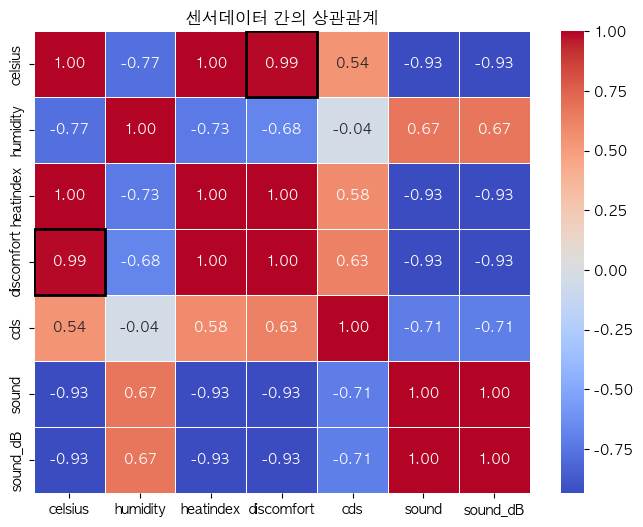

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

set_graph_font()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# 온도와 불쾌지수의 상관관계 (굵은 테두리)
i = features.index('celsius')
j = features.index('discomfort')
for (row, col) in [(i, j), (j, i)]:
    ax.add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='black', lw=2))

plt.title('센서데이터 간의 상관관계')
plt.show()

# 온도, 체감온도, 불쾌지수는 서로 매우 강하게 연결되어 있음(거의 같은 값처럼 움직임)
# 온도와 소음은 반비례(온도가 높을수록 소음이 낮음)
# 습도와 소음은 비례(습도가 높을수록 소음도 높음)
# 조도는 온도, 불쾌지수와 중간 정도의 양의 상관, 소음과는 음의 상관
# 불쾌지수를 낮추려면 온도와 체감온도를 낮추는 것이 가장 효과적임

### 3. 군집 분석 (Clustering)
- 실내외 환경이 명확하게 구분되는가? 군집 분석(K-mean, PCA)

- 위치별 환경 구분이 명확 : house, station, outdoor 등은 각각 매우 다른 환경 특성을 가짐. PCA로 잘 분리됨.  
- 실내 vs 실외 분리 가능 ( K-mean )  
   : 클러스터 수 측정방식 ( )

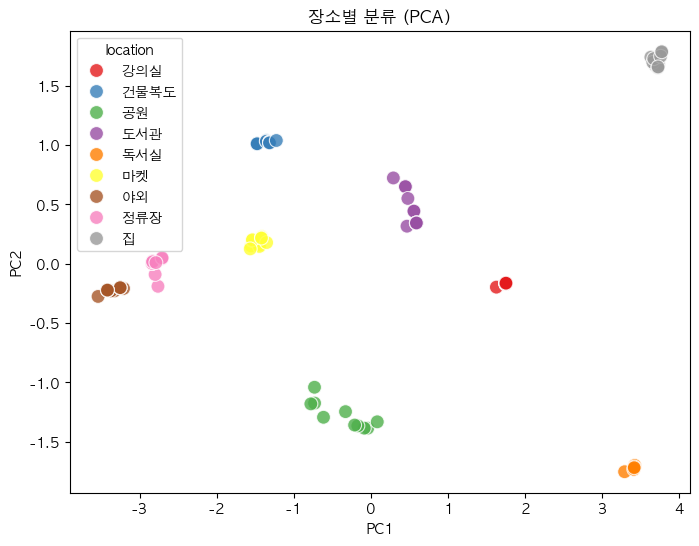

In [27]:
from sklearn.decomposition import PCA

set_graph_font()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['location'] = df['location']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='location', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title('장소별 분류 (PCA)')
plt.show()

Elbow Method 최적의 K 값: 7
최적의 silhouette K 값: 9
최적의 davies_bouldin_score K 값: 9


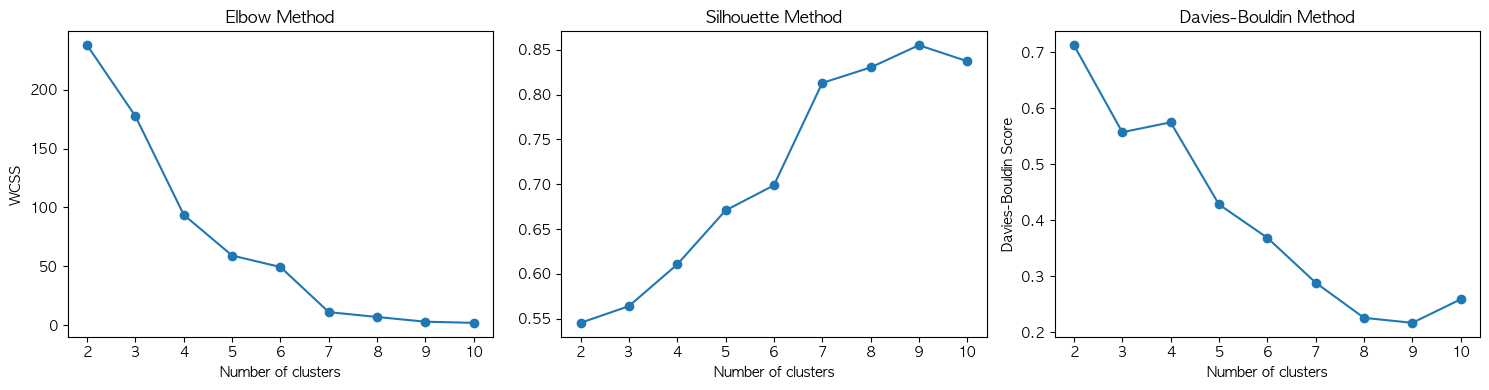

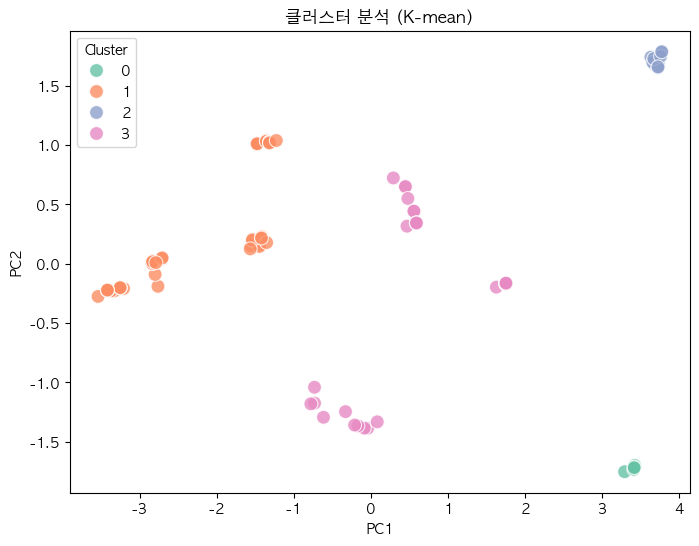

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator

# 군집의 범위 지정 
range_n_clusters = range(2, 11)
wcss = []
silhouette_scores = []
db_scores = []

# 5. 각 지표 계산 루프
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)

    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    db_scores.append(davies_bouldin_score(scaled_features, labels))

#print(wcss)
#print(silhouette_scores)
#print(db_scores)

## 최적의 K 값을 찾기 
kneedle = KneeLocator(range_n_clusters, wcss, curve="convex", direction="decreasing")
elbow_k = kneedle.elbow
print(f"Elbow Method 최적의 K 값: {elbow_k}")
silhouette_k = silhouette_scores.index(max(silhouette_scores))+2
print(f"최적의 silhouette K 값: {silhouette_k}")
db_k = db_scores.index(min(db_scores))+2
print(f"최적의 davies_bouldin_score K 값: {db_k}")

# 6. 시각화
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 3, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')

plt.subplot(1, 3, 3)
plt.plot(range_n_clusters, db_scores, marker='o')
plt.title('Davies-Bouldin Method')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

## Elow Method 최적의 값을 보면 7 이지만 완만해 지는 시점인 4를 기준으로 K-mean 측정
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
pca_df['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2', s=100, alpha=0.8)
plt.title('클러스터 분석 (K-mean)')
plt.show()

### 4. 회귀분석
- 다중공선성 처리 

In [29]:
## 다중공선성 처리 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# celsius, heatindex, discomfort 파생된값이므로 하나만 사용
# sound, sound_dB 중에 하나만 사용
features = ['celsius', 'humidity', 'cds', 'sound_dB']
X = df[features]
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=features)

vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# 다중공선성이 심하면 회귀계수의 해석이 왜곡, p-value 증가 -> 의미없는 통계처럼 보일수 있음 (예측력 저하)
print(vif_data)

    feature        VIF
0   celsius  10.557165
1  humidity   6.686595
2       cds   6.533214
3  sound_dB  17.803251


- scikit-learn 을 이용한 선형회귀

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 불쾌지수를 종속변수로 온도/습도/조도/소음을 독립변수로 사용 
Xx = df[['celsius', 'humidity', 'cds', 'sound_dB']]
Yy = df['discomfort']

# 모델 학습
x_train, x_test, y_train, y_test = train_test_split(Xx, Yy, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(Xx, Yy)

# 회귀계수 
print("회귀계수 : ", model.coef_)
print("절편 : ", model.intercept_)
# 결정계수
print("훈련 R² : ", model.score(x_train, y_train))
print("테스트 R² : ", model.score(x_test, y_test))

회귀계수 :  [1.30905525e+00 9.22953341e-02 1.61617611e-03 2.02705573e+00]
절편 :  21.893531916831733
훈련 R² :  0.9982920213970988
테스트 R² :  0.9989815720163083


* 온도가 1도 오를때 불쾌지수(종속변수)가 1.309 만큼 증가 
* 소음이 1dB 오를때 불쾌지수(종속변수)가 2.027 만큼 증가 
* 절편(21.89) : 모든 독립변수가 0일때 불쾌지수는 21.89 
* 결정계수 R²(0.9989) 거의 1에 가까움 -> 모델이 종속변수(불쾌지수)의 변동을 99.8% (입력한 독립변수들로 불쾌지수를 매우 정확하게 예측 가능함)

In [33]:
import scipy.stats as stats

intercept = model.intercept_
coefs = model.coef_
variables = Xx

terms = [f"{coef:.4f} * {var}" for coef, var in zip(coefs, variables)]
equation = " + ".join(terms)
equation = f"Y(불쾌지수) = {intercept:.4f} + {equation}"

print("회귀식 : ", equation)


회귀식 :  Y(불쾌지수) = 21.8935 + 1.3091 * celsius + 0.0923 * humidity + 0.0016 * cds + 2.0271 * sound_dB


### 분석 결론 요약  
1. 쾌적한 환경(공부하기 좋은 장소)  
도서관, 복도, 집 등이 쾌적도 점수가 높아 공부하기 좋은 환경으로 평가됨  
야외, 정류장 등은 온도, 소음, 조도 등에서 극단적 특성을 보여 쾌적도가 낮음  

2. 주요 변수의 영향력  
온도, 체감온도, 불쾌지수는 서로 매우 강한 양의 상관관계를 보임 → 온도가 높을수록 불쾌지수도 높아짐  
소음은 온도와 음의 상관관계, 습도와 양의 상관관계 → 소음이 낮고 온도/습도가 적절할 때 쾌적도가 높음  
조도는 쾌적도에 중간 정도의 영향  

3. 회귀분석 결과  
온도, 습도, 소음이 불쾌지수(쾌적도)에 유의미한 영향을 미침  
회귀모델의 설명력이 매우 높아(예: R² ≈ 0.99),이 변수들로 쾌적도를 매우 정확하게 예측 가능  

4. 군집분석 결과  
실내(집, 도서관, 강의실, 독서실)와 실외(야외, 공원) 환경이 명확히 구분됨  
각 장소별로 환경 특성이 뚜렷하게 다름  

5. 잔차분석 결과  
잔차가 0에 가까우며, 정규분포와 등분산성 가정도 대체로 만족 → 회귀모델이 데이터 구조를 잘 설명함